# Fake news classification (RU)


In [1]:
import pandas as pd
import numpy as np

np.random.seed(420)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## EDA

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/fake_news/train.tsv', sep='\t')
test_data = pd.read_csv('/content/drive/MyDrive/fake_news/test.tsv', sep='\t')

train_data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [3]:
train_data['is_fake'].value_counts()

,count
is_fake,
1,2879
0,2879


<Axes: >

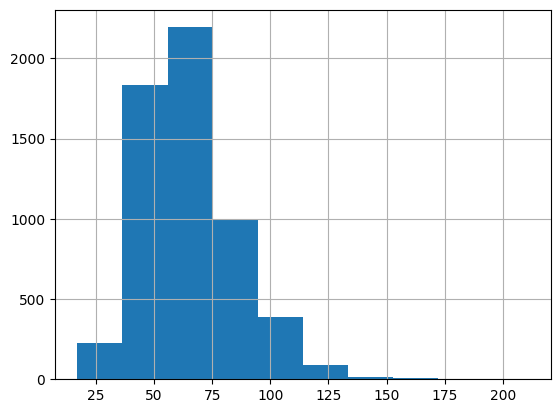

In [4]:
train_data['title'].str.len().hist()

In [5]:
MAX_SEQ_LENGTH = max(train_data['title'].str.len())
MAX_SEQ_LENGTH

211

In [6]:
from sklearn.model_selection import train_test_split
import nltk

nltk.download('stopwords')

train_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/fake_news')


from preprocess import get_lemmas_from_text

train_data['lemmas'] = get_lemmas_from_text(train_data['title'])
test_data['lemmas'] = get_lemmas_from_text(test_data['title'])
train_data.head()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,title,is_fake,lemmas
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутин приходить счет вмешате...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин называть езда встречок житейский...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассматривать возможность введение сек...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный заводить дело недоносительств...


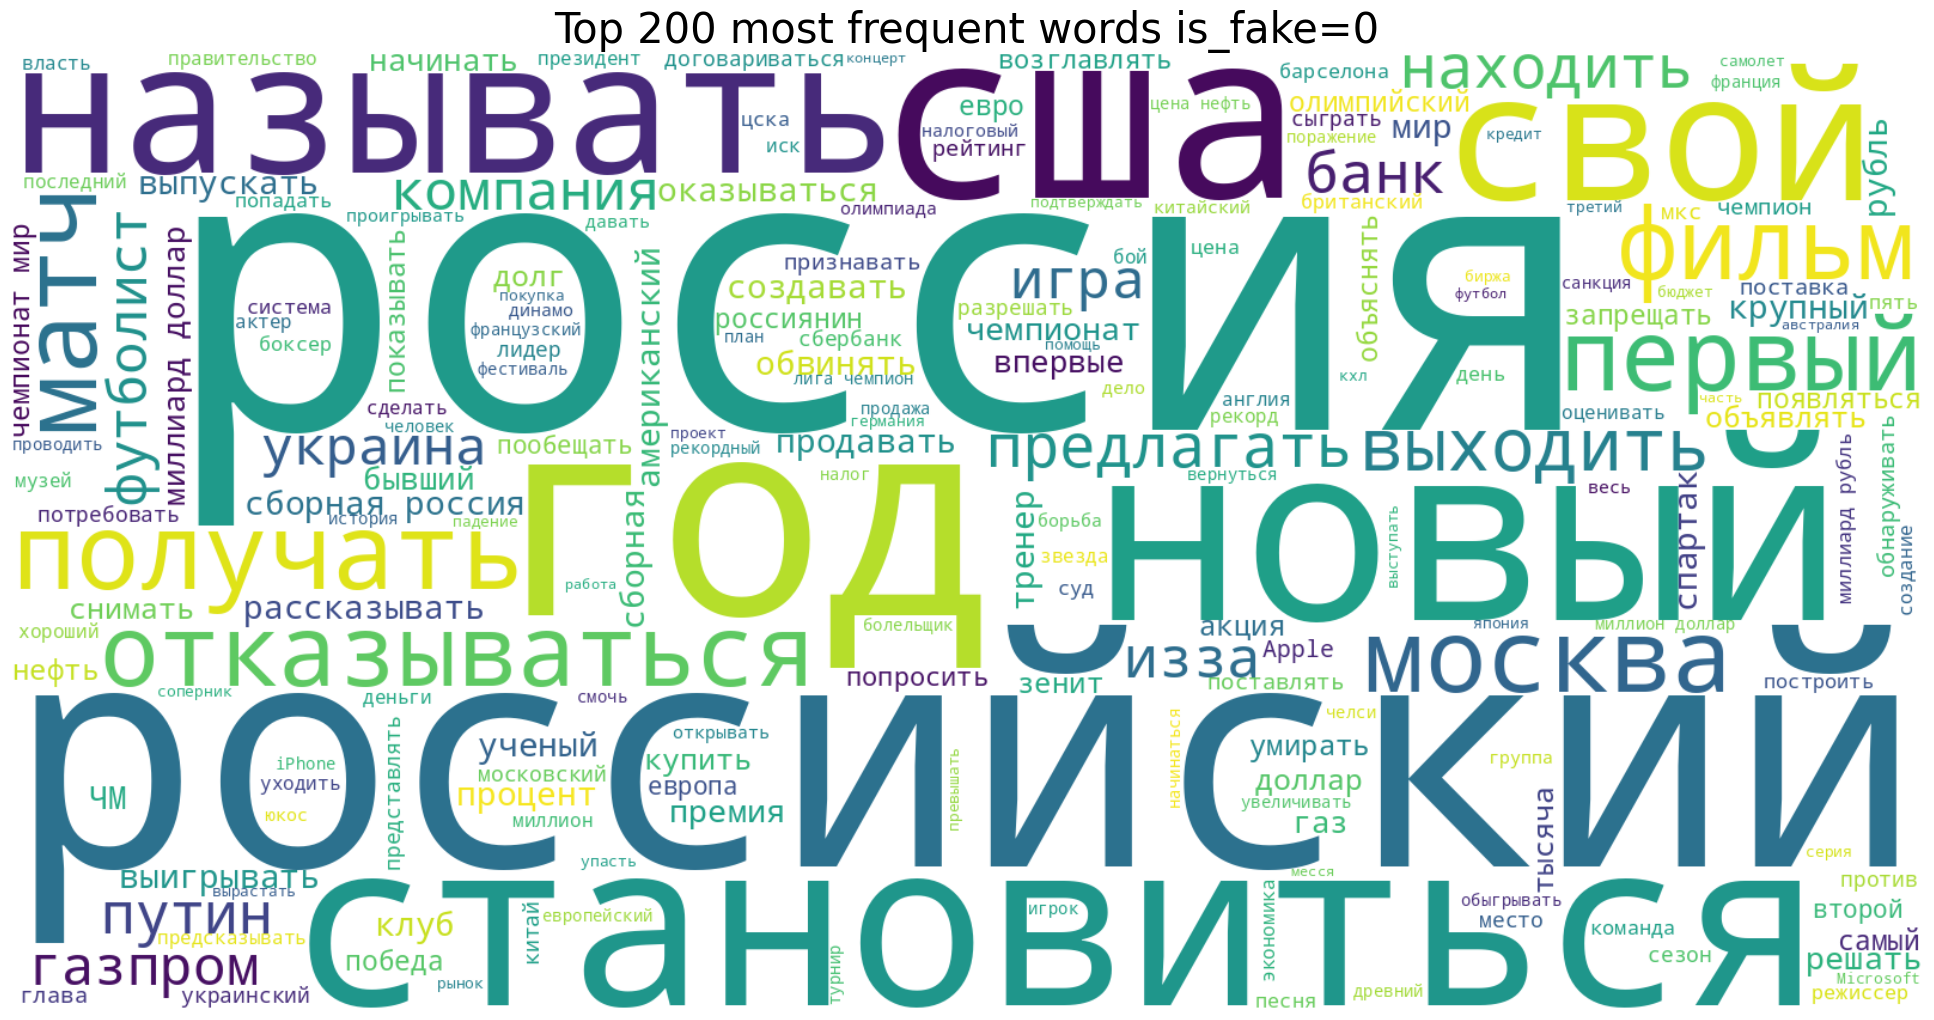

In [ ]:
from visualize import get_wordcloud

get_wordcloud(train_data[train_data['is_fake']==0]['lemmas'], title='Top 200 most frequent words is_fake=0')

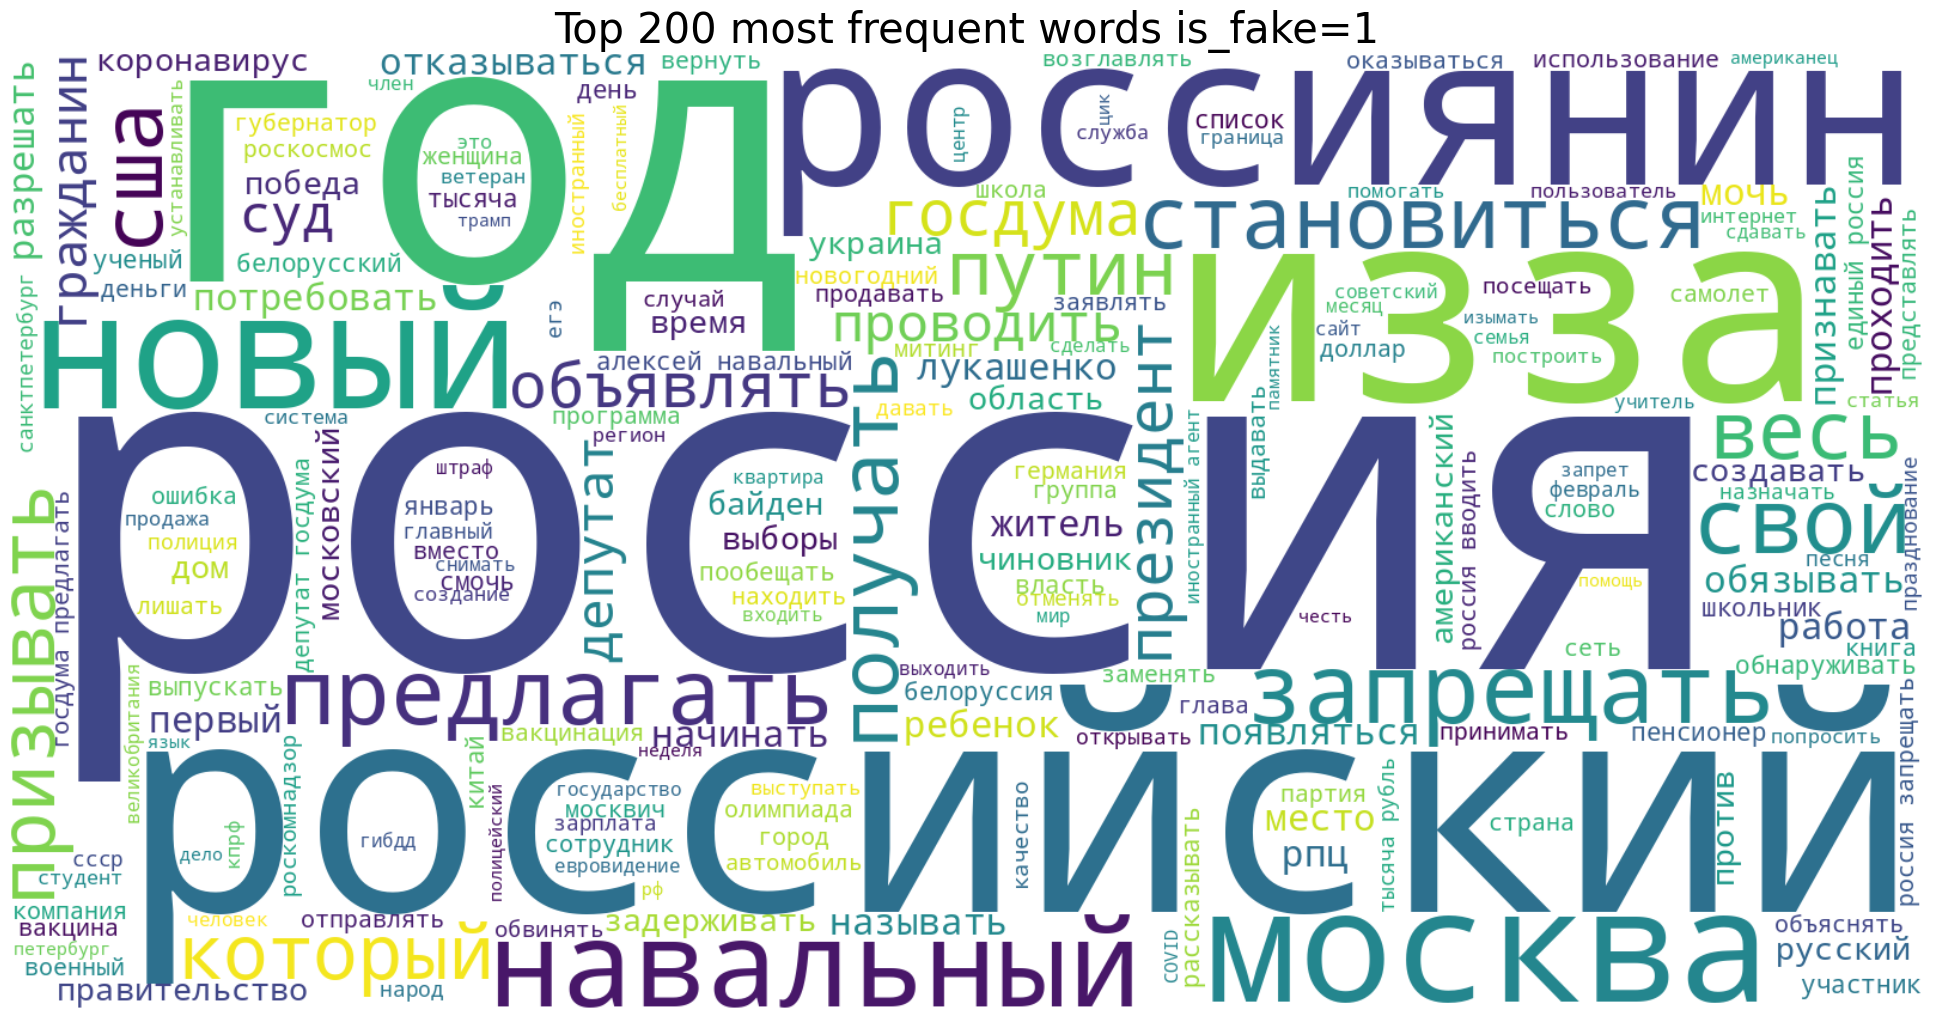

In [ ]:
get_wordcloud(train_data[train_data['is_fake']==1]['lemmas'], title='Top 200 most frequent words is_fake=1')

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_data.drop('title',axis=1), test_size=0.2, random_state=42, stratify=train_data['is_fake'])

print("total train examples %s" % len(train))
print("total test examples %s\n" % len(val))
print(train['is_fake'].value_counts())

total train examples 4606
total test examples 1152

is_fake
1    2303
0    2303
Name: count, dtype: int64


In [ ]:
import os

preprocessed_path = "/content/drive/MyDrive/fake_news/preprocessed"

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

train.to_csv(preprocessed_path + '/train.csv')
val.to_csv(preprocessed_path + '/val.csv')
test_data.to_csv(preprocessed_path + '/test.csv')

## Modelling

In [ ]:
import torch
from sklearn.metrics import classification_report

task_type = "GPU" if torch.cuda.is_available() else "CPU"

### PAC

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

tfidf = TfidfVectorizer()
vec_train = tfidf.fit_transform(train['lemmas'])
vec_val = tfidf.transform(val['lemmas'])

pac = PassiveAggressiveClassifier(C = 0.01)

pac.fit(vec_train, train['is_fake'])
val_pred = pac.predict(vec_val)


print(classification_report(val['is_fake'], val_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       576
           1       0.85      0.85      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



### Fasttext baseline


In [ ]:
! pip install fasttext

import fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296185 sha256=28686abc1eab98301f0fa9fd69417c2c0844e376ef1c1cd822e537daa87d839e
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
#Write data to file for fasttext classifier
fasttext_path = "/content/drive/MyDrive/fake_news/fasttext"

if not os.path.exists(fasttext_path):
    os.makedirs(fasttext_path)

with open(fasttext_path + '/data.train.txt', 'w+') as outfile:
    for x, y in zip(train['lemmas'], train['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')


with open(fasttext_path + '/test.txt', 'w+') as outfile:
    for x, y in zip(val['lemmas'], val['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')

In [ ]:
classifier = fasttext.train_supervised(fasttext_path + '/data.train.txt', lr=1.0, epoch=25, wordNgrams=3)

num, precision, recall = classifier.test(fasttext_path + '/test.txt')

print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print('Number of examples:', num)

Precision: 0.85764
Recall: 0.85764
Number of examples: 1152


### CatBoost

In [ ]:
! pip install catboost

from catboost import Pool, CatBoostClassifier

train_pool = Pool(data=
    train.drop(['is_fake'], axis=1),
    label=train['is_fake'],
    text_features = ['lemmas']
)

valid_pool = Pool(data=
    val.drop(['is_fake'], axis=1),
    label=val['is_fake'],
    text_features=['lemmas']
)

model = CatBoostClassifier(verbose=10, use_best_model=True, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
Learning rate set to 0.062538
0:	learn: 0.6590950	test: 0.6522286	best: 0.6522286 (0)	total: 54.7ms	remaining: 54.7s
10:	learn: 0.4837612	test: 0.4412399	best: 0.4412399 (10)	total: 413ms	remaining: 37.1s
20:	learn: 0.4293577	test: 0.3867066	best: 0.3867066 (20)	total: 661ms	remaining: 30.8s
30:	learn: 0.4125920	test: 0.3709156	best: 0.3709156 (30)	total: 918ms	remaining: 28.7s
40:	learn: 0.4051046	test: 0.3666011	best: 0.3666011 (40)	total: 1.17s	remaining: 27.3s
50:	learn: 0.3985027	test: 0.3625727	best: 0.3625727 (50)	total: 1.41s	remaining: 26.3s
60:	learn: 0.3933829	test: 0.3607407	best: 0.3607407 (60)	total: 1.66s	remaining: 25.6s
70:	learn: 0.3894494	test: 0.3593337	best: 0.3593337 (70)	total: 1.92s	remaining: 25.2s
80:	learn: 0.3868020	test: 0.3587029	best: 0.3586835 (79)	total: 2.17s	remaining: 24.6s
90:	learn: 0.3839758	test: 0.3581989	best: 0.3581156 (88)	total: 2.4s	remaining: 24s
100:	learn: 0.38

In [ ]:
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       576
           1       0.86      0.83      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



### RuBERT


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from transformers import AutoTokenizer

TOKENIZER_NAME = "cointegrated/rubert-tiny2"
MODEL_NAME = "cointegrated/rubert-tiny2"
SAVED_MODEL_NAME = MODEL_NAME.split("/", 1)[1]
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from preprocess import convert_examples_to_inputs
from preprocess import get_data_loader

train_features = convert_examples_to_inputs(
    train['lemmas'], train['is_fake'], MAX_SEQ_LENGTH, tokenizer)
val_features = convert_examples_to_inputs(
    val['lemmas'], val['is_fake'], MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, BATCH_SIZE, shuffle=False)

In [ ]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
out_features = model.bert.encoder.layer[1].output.dense.out_features
model.classifier = torch.nn.Linear(out_features, 2)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5
PATIENCE = 4
OUTPUT_DIR = "/content/drive/MyDrive/fake_news/trained_models/"


model.to(device)

num_train_steps = int(len(train_dataloader.dataset) /
                      BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)

num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from model import train_model

config = (int(NUM_TRAIN_EPOCHS), GRADIENT_ACCUMULATION_STEPS, MAX_GRAD_NORM, SAVED_MODEL_NAME)
train_model(device, model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, config)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.014821684919297695
Dev F1: 0.7441860465116279
New record, model saved to trained_models/rubert-tiny2


Epoch:  10%|█         | 1/10 [00:14<02:08, 14.26s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.014821684919297695]
Dev loss: 0.009106007404625416
Dev F1: 0.8434782608695652
New record, model saved to trained_models/rubert-tiny2


Epoch:  20%|██        | 2/10 [00:26<01:45, 13.23s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.014821684919297695, 0.009106007404625416]
Dev loss: 0.01107199490070343
Dev F1: 0.8481581311769991
New record, model saved to trained_models/rubert-tiny2


Epoch:  30%|███       | 3/10 [00:39<01:30, 12.95s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.014821684919297695, 0.009106007404625416, 0.01107199490070343]
Dev loss: 0.011551265604794025
Dev F1: 0.8530721282279609
New record, model saved to trained_models/rubert-tiny2


Epoch:  40%|████      | 4/10 [00:52<01:17, 12.86s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  50%|█████     | 5/10 [01:04<01:03, 12.71s/it]

Loss history: [0.009106007404625416, 0.01107199490070343, 0.011551265604794025]
Dev loss: 0.01244510430842638
Dev F1: 0.8510258697591436


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.01107199490070343, 0.011551265604794025, 0.01244510430842638]
Dev loss: 0.011424210853874683
Dev F1: 0.8576388888888888
New record, model saved to trained_models/rubert-tiny2


Epoch:  60%|██████    | 6/10 [01:17<00:50, 12.75s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.011551265604794025, 0.01244510430842638, 0.011424210853874683]
Dev loss: 0.011354868300259113
Dev F1: 0.8623376623376623
New record, model saved to trained_models/rubert-tiny2


Epoch:  70%|███████   | 7/10 [01:30<00:38, 12.77s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.01244510430842638, 0.011424210853874683, 0.011354868300259113]
Dev loss: 0.013002646155655384
Dev F1: 0.8626421697287839
New record, model saved to trained_models/rubert-tiny2


Epoch:  80%|████████  | 8/10 [01:43<00:25, 12.79s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.011424210853874683, 0.011354868300259113, 0.013002646155655384]
Dev loss: 0.013738950714468956
Dev F1: 0.8649602824360106
New record, model saved to trained_models/rubert-tiny2


Epoch:  90%|█████████ | 9/10 [01:55<00:12, 12.83s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.011354868300259113, 0.013002646155655384, 0.013738950714468956]
Dev loss: 0.01364257000386715
Dev F1: 0.8661971830985915
New record, model saved to trained_models/rubert-tiny2


Epoch: 100%|██████████| 10/10 [02:08<00:00, 12.89s/it]


In [ ]:
from utils import val_report

model = BertForSequenceClassification.from_pretrained('')

dev_correct, dev_predicted = val_report(device, model, train_dataloader, val_dataloader, loss_fn)

OSError: Incorrect path_or_model_id: ''. Please provide either the path to a local folder or the repo_id of a model on the Hub.

## Test inference (BERT)

In [ ]:
from model import evaluate

test_features = convert_examples_to_inputs(test_data['lemmas'], test_data['is_fake'], MAX_SEQ_LENGTH, tokenizer)
test_dataloader = get_data_loader(test_features, BATCH_SIZE, shuffle=False)

_, _, predicted_labels = evaluate(device, model, test_dataloader, loss_fn)

In [ ]:
from pathlib import Path

path = Path('/content/drive/MyDrive/fake_news/prediction.tsv').resolve()
prediction = pd.DataFrame({'title':test_data['title'], 'is_fake':pd.Series(predicted_labels)})
prediction.to_csv(path, sep='\t', index=False)